In [29]:
import numpy as np

# Define file paths (update if needed)
linear_synthetic_eeg_eog_path = "/home/tulgaa/Desktop/denoisenet/Linear_Mixing/EEG+EOG/Linear_synthetic_eeg_eog.npy"
eeg_all_epochs_path = "/home/tulgaa/Desktop/denoisenet/Linear_Mixing/EEG+EOG/EEG_all_epochs.npy"

# Load datasets
linear_synthetic_data = np.load(linear_synthetic_eeg_eog_path, allow_pickle=True).item()
eeg_clean_data = np.load(eeg_all_epochs_path)

# Print dataset keys (SNR levels)
print("Noisy EEG+EOG SNR Levels:", linear_synthetic_data.keys())

# Check dataset shapes
print("Shape of Clean EEG Data:", eeg_clean_data.shape)
for snr in linear_synthetic_data.keys():
    print(f"Shape of Noisy EEG+EOG Data at SNR {snr}: {linear_synthetic_data[snr].shape}")


Noisy EEG+EOG SNR Levels: dict_keys([-7, -6, -5, -4, -3, -2, -1, 0, 1, 2])
Shape of Clean EEG Data: (3400, 512)
Shape of Noisy EEG+EOG Data at SNR -7: (3400, 512)
Shape of Noisy EEG+EOG Data at SNR -6: (3400, 512)
Shape of Noisy EEG+EOG Data at SNR -5: (3400, 512)
Shape of Noisy EEG+EOG Data at SNR -4: (3400, 512)
Shape of Noisy EEG+EOG Data at SNR -3: (3400, 512)
Shape of Noisy EEG+EOG Data at SNR -2: (3400, 512)
Shape of Noisy EEG+EOG Data at SNR -1: (3400, 512)
Shape of Noisy EEG+EOG Data at SNR 0: (3400, 512)
Shape of Noisy EEG+EOG Data at SNR 1: (3400, 512)
Shape of Noisy EEG+EOG Data at SNR 2: (3400, 512)


In [30]:
from sklearn.model_selection import train_test_split
import numpy as np

# Initialize lists to store training and testing data per SNR level
X_train_list, X_test_list, Y_train_list, Y_test_list = [], [], [], []

# Loop through each SNR level and perform train-test split
for snr in linear_synthetic_data.keys():
    noisy_signals = linear_synthetic_data[snr]  # Noisy EEG+EOG
    clean_signals = eeg_clean_data  # Ground truth (same for all SNRs)

    # Train-test split (80% train, 20% test)
    X_train_snr, X_test_snr, Y_train_snr, Y_test_snr = train_test_split(
        noisy_signals, clean_signals, test_size=0.2, random_state=42  # **Seed Applied Here**
    )

    # Store per-SNR test sets
    X_train_list.append(X_train_snr)
    X_test_list.append(X_test_snr)
    Y_train_list.append(Y_train_snr)
    Y_test_list.append(Y_test_snr)

# Stack all train and test data together
X_train = np.concatenate(X_train_list, axis=0)
X_test = np.concatenate(X_test_list, axis=0)
Y_train = np.concatenate(Y_train_list, axis=0)
Y_test = np.concatenate(Y_test_list, axis=0)

# Print final dataset sizes
print("✅ Final Dataset Sizes:")
print("X_train (Noisy):", X_train.shape)
print("Y_train (Clean):", Y_train.shape)
print("X_test  (Noisy):", X_test.shape)
print("Y_test  (Clean):", Y_test.shape)


✅ Final Dataset Sizes:
X_train (Noisy): (27200, 512)
Y_train (Clean): (27200, 512)
X_test  (Noisy): (6800, 512)
Y_test  (Clean): (6800, 512)


In [31]:
import torch
import torch.nn as nn

# Corrected 1D-ResCNN Model
class ResCNN1D(nn.Module):
    def __init__(self):
        super(ResCNN1D, self).__init__()

        # Parallel Convolutional Layers (Different Kernel Sizes)
        self.conv3 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv9 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=9, stride=1, padding=4)

        # Batch Normalization
        self.bn3 = nn.BatchNorm1d(64)
        self.bn5 = nn.BatchNorm1d(64)
        self.bn9 = nn.BatchNorm1d(64)

        # Activation Function
        self.relu = nn.ReLU()

        # Residual Connection (Merging Parallel Conv Outputs)
        self.res_conv = nn.Conv1d(in_channels=192, out_channels=64, kernel_size=1, stride=1)

        # Second Convolutional Block (Refining Features)
        self.conv_out = nn.Conv1d(in_channels=64, out_channels=1, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension (Batch, 1, 512)

        # Apply Parallel Convolutions
        x3 = self.relu(self.bn3(self.conv3(x)))
        x5 = self.relu(self.bn5(self.conv5(x)))
        x9 = self.relu(self.bn9(self.conv9(x)))

        # Concatenate Parallel Outputs
        x = torch.cat([x3, x5, x9], dim=1)  # Shape: (Batch, 192, 512)

        # Residual Connection (Merging Features)
        x = self.res_conv(x)  # Shape: (Batch, 64, 512)

        # Output Layer
        x = self.conv_out(x)  # Shape: (Batch, 1, 512)
        x = x.squeeze(1)  # Remove channel dimension (Back to (Batch, 512))
        
        return x

# Initialize Model and Print Summary
model = ResCNN1D()
print(model)


ResCNN1D(
  (conv3): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv5): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv9): Conv1d(1, 64, kernel_size=(9,), stride=(1,), padding=(4,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (res_conv): Conv1d(192, 64, kernel_size=(1,), stride=(1,))
  (conv_out): Conv1d(64, 1, kernel_size=(9,), stride=(1,), padding=(4,))
)


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Define EEG dataset class
class EEGDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Convert data to PyTorch tensors
train_dataset = EEGDataset(X_train, Y_train)
test_dataset = EEGDataset(X_test, Y_test)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResCNN1D().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
patience = 5  # Stop training if validation loss does not improve for 'patience' epochs
min_val_loss = float('inf')
patience_counter = 0

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Compute average training loss
    train_loss /= len(train_loader)

    # Validation Phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, Y_val in test_loader:
            X_val, Y_val = X_val.to(device), Y_val.to(device)
            val_outputs = model(X_val)
            val_loss += criterion(val_outputs, Y_val).item()

    # Compute average validation loss
    val_loss /= len(test_loader)

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}")

    # Early stopping check
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        patience_counter = 0  # Reset counter
        torch.save(model.state_dict(), "1D_ResCNN_Best.pth")  # Save best model
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered! 🚀")
        break

print("Training complete! Best model saved as '1D_ResCNN_Best.pth'.")


Epoch 1/50 - Train Loss: 26996.578824 - Val Loss: 19578.183877
Epoch 2/50 - Train Loss: 19257.713084 - Val Loss: 19170.269458
Epoch 3/50 - Train Loss: 19045.078456 - Val Loss: 19029.497198
Epoch 4/50 - Train Loss: 18911.176089 - Val Loss: 18915.165523
Epoch 5/50 - Train Loss: 18811.280977 - Val Loss: 18832.676228
Epoch 6/50 - Train Loss: 18694.610614 - Val Loss: 18825.937153
Epoch 7/50 - Train Loss: 18592.873709 - Val Loss: 18554.443076
Epoch 8/50 - Train Loss: 18495.962778 - Val Loss: 18664.966359
Epoch 9/50 - Train Loss: 18424.965074 - Val Loss: 19213.117215
Epoch 10/50 - Train Loss: 18355.925485 - Val Loss: 18427.514530
Epoch 11/50 - Train Loss: 18302.335294 - Val Loss: 18353.003258
Epoch 12/50 - Train Loss: 18227.557160 - Val Loss: 18898.974701
Epoch 13/50 - Train Loss: 18191.131340 - Val Loss: 18366.662547
Epoch 14/50 - Train Loss: 18186.353752 - Val Loss: 18232.055965
Epoch 15/50 - Train Loss: 18152.910466 - Val Loss: 18097.701053
Epoch 16/50 - Train Loss: 18119.069297 - Val Loss

In [19]:
import torch
import numpy as np
from scipy.fft import fft
import pandas as pd

# Load the best-trained model (with early stopping)
model.load_state_dict(torch.load("1D_ResCNN_Best.pth"))
model.eval()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Storage for results per SNR
snr_results = {}

# Loop over each SNR level and compute evaluation metrics
for snr in sorted(linear_synthetic_data.keys()):  # Ensure SNR levels are in order
    print(f"Evaluating SNR Level: {snr}")

    # Get noisy signals at this SNR
    X_test_snr = linear_synthetic_data[snr]
    Y_test_snr = eeg_clean_data  # Clean EEG remains the same

    # Convert to PyTorch tensors
    X_test_tensor = torch.tensor(X_test_snr, dtype=torch.float32).to(device)
    Y_test_tensor = torch.tensor(Y_test_snr, dtype=torch.float32).to(device)

    # Get model predictions
    with torch.no_grad():
        Y_pred_tensor = model(X_test_tensor)

    # Convert tensors to numpy for evaluation
    Y_clean = Y_test_tensor.cpu().numpy()
    Y_denoised = Y_pred_tensor.cpu().numpy()

    # Compute RRMSE_Temporal (Time Domain)
    rrmse_t = np.linalg.norm(Y_clean - Y_denoised) / np.linalg.norm(Y_clean)

    # Compute RRMSE_Spectral (Frequency Domain)
    clean_fft = np.abs(fft(Y_clean, axis=-1))  # Compute FFT of clean EEG
    denoised_fft = np.abs(fft(Y_denoised, axis=-1))  # Compute FFT of denoised EEG
    rrmse_s = np.linalg.norm(clean_fft - denoised_fft) / np.linalg.norm(clean_fft)

    # Compute Correlation Coefficient (CC)
    num = np.sum((Y_clean - np.mean(Y_clean)) * (Y_denoised - np.mean(Y_denoised)))
    den = np.sqrt(np.sum((Y_clean - np.mean(Y_clean))**2) * np.sum((Y_denoised - np.mean(Y_denoised))**2))
    cc = num / den

    # Compute T&S Metric
    T_S = 10 * np.log10(np.sum(Y_clean**2) / np.sum((Y_clean - Y_denoised)**2))

    # Store results
    snr_results[snr] = {
        "RRMSE_T (Temporal)": rrmse_t,
        "RRMSE_S (Spectral)": rrmse_s,
        "CC (Correlation Coefficient)": cc,
        "T&S Metric (dB)": T_S
    }

    # Print results for this SNR
    print(f"  RRMSE_T: {rrmse_t:.4f}")
    print(f"  RRMSE_S: {rrmse_s:.4f}")
    print(f"  Correlation Coefficient (CC): {cc:.4f}")
    print(f"  T&S Metric: {T_S:.4f} dB\n")

# Convert results to Pandas DataFrame for easy viewing
df_results = pd.DataFrame.from_dict(snr_results, orient="index")
df_results.index.name = "SNR Level"
df_results = df_results.sort_index()  # Sort by SNR level

# Compute Average RRMSE_T and RRMSE_S across all SNR levels
avg_rrmse_t = df_results["RRMSE_T (Temporal)"].mean()
avg_rrmse_s = df_results["RRMSE_S (Spectral)"].mean()

# Print Final Summary
print("\n==== Final Evaluation Summary ====")
print(f"Average RRMSE_T (Temporal): {avg_rrmse_t:.4f}")
print(f"Average RRMSE_S (Spectral): {avg_rrmse_s:.4f}")

# Display final results as a table
print("\n==== Evaluation Results per SNR ====")
print(df_results)

Evaluating SNR Level: -7
  RRMSE_T: 0.6884
  RRMSE_S: 0.5231
  Correlation Coefficient (CC): 0.7313
  T&S Metric: 3.2427 dB

Evaluating SNR Level: -6
  RRMSE_T: 0.6536
  RRMSE_S: 0.5086
  Correlation Coefficient (CC): 0.7591
  T&S Metric: 3.6944 dB

Evaluating SNR Level: -5
  RRMSE_T: 0.6249
  RRMSE_S: 0.4955
  Correlation Coefficient (CC): 0.7814
  T&S Metric: 4.0837 dB

Evaluating SNR Level: -4
  RRMSE_T: 0.6002
  RRMSE_S: 0.4832
  Correlation Coefficient (CC): 0.8000
  T&S Metric: 4.4347 dB

Evaluating SNR Level: -3
  RRMSE_T: 0.5777
  RRMSE_S: 0.4712
  Correlation Coefficient (CC): 0.8162
  T&S Metric: 4.7655 dB

Evaluating SNR Level: -2
  RRMSE_T: 0.5566
  RRMSE_S: 0.4593
  Correlation Coefficient (CC): 0.8309
  T&S Metric: 5.0887 dB

Evaluating SNR Level: -1
  RRMSE_T: 0.5360
  RRMSE_S: 0.4473
  Correlation Coefficient (CC): 0.8446
  T&S Metric: 5.4171 dB

Evaluating SNR Level: 0
  RRMSE_T: 0.5151
  RRMSE_S: 0.4359
  Correlation Coefficient (CC): 0.8579
  T&S Metric: 5.7620 dB

E

In [33]:
import torch
import numpy as np
from scipy.fft import fft
import pandas as pd

# Load the best-trained model (with early stopping)
model.load_state_dict(torch.load("1D_ResCNN_Best.pth"))
model.eval()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Storage for results per SNR
snr_results = {}

# Loop through each SNR level and use the pre-split test data
with torch.no_grad():
    for snr_idx, snr in enumerate(sorted(linear_synthetic_data.keys())):  # Ensure SNR levels are sorted
        print(f"Evaluating SNR Level: {snr}")

        # Get test data from the pre-split test set
        X_test_snr = X_test_list[snr_idx]  # Noisy EEG (from test set)
        Y_test_snr = Y_test_list[snr_idx]  # Clean EEG (from test set)

        # Convert to PyTorch tensors
        X_test_tensor = torch.tensor(X_test_snr, dtype=torch.float32).to(device)
        Y_test_tensor = torch.tensor(Y_test_snr, dtype=torch.float32).to(device)

        # Get model predictions
        Y_pred_tensor = model(X_test_tensor)

        # Convert tensors to numpy for evaluation
        Y_clean = Y_test_tensor.cpu().numpy()
        Y_denoised = Y_pred_tensor.cpu().numpy()

        # Compute RRMSE_Temporal (Time Domain)
        rrmse_t = np.linalg.norm(Y_clean - Y_denoised) / np.linalg.norm(Y_clean)

        # Compute RRMSE_Spectral (Frequency Domain)
        clean_fft = np.abs(fft(Y_clean, axis=-1))  # Compute FFT of clean EEG
        denoised_fft = np.abs(fft(Y_denoised, axis=-1))  # Compute FFT of denoised EEG
        rrmse_s = np.linalg.norm(clean_fft - denoised_fft) / np.linalg.norm(clean_fft)

        # Compute Correlation Coefficient (CC)
        num = np.sum((Y_clean - np.mean(Y_clean)) * (Y_denoised - np.mean(Y_denoised)))
        den = np.sqrt(np.sum((Y_clean - np.mean(Y_clean))**2) * np.sum((Y_denoised - np.mean(Y_denoised))**2))
        cc = num / den

        # Compute T&S Metric
        T_S = 10 * np.log10(np.sum(Y_clean**2) / np.sum((Y_clean - Y_denoised)**2))

        # Store results
        snr_results[snr] = {
            "RRMSE-T": rrmse_t,
            "RRMSE-S": rrmse_s,
            "CC": cc,
            "T&S Metric (dB)": T_S
        }

        # Print results for this SNR
        print(f"  RRMSE-T: {rrmse_t:.4f}")
        print(f"  RRMSE-S: {rrmse_s:.4f}")
        print(f"  Correlation Coefficient (CC): {cc:.4f}")
        print(f"  T&S Metric: {T_S:.4f} dB\n")

# Convert results to Pandas DataFrame for easy viewing
df_results = pd.DataFrame.from_dict(snr_results, orient="index")
df_results.index.name = "SNR Level"
df_results = df_results.sort_index()  # Sort by SNR level

# Compute Overall Averages
avg_rrmse_t = df_results["RRMSE-T"].mean()
avg_rrmse_s = df_results["RRMSE-S"].mean()
avg_cc = df_results["CC"].mean()

# Print Final Summary
print("\n==== Final Evaluation Summary ====")
print(f"✅ Average RRMSE-T: {avg_rrmse_t:.6f}")
print(f"✅ Average RRMSE-S: {avg_rrmse_s:.6f}")
print(f"✅ Average CC: {avg_cc:.6f}")

# Display final results as a table
print("\n==== Evaluation Results per SNR ====")
print(df_results)


Evaluating SNR Level: -7
  RRMSE-T: 0.6943
  RRMSE-S: 0.5235
  Correlation Coefficient (CC): 0.7259
  T&S Metric: 3.1692 dB

Evaluating SNR Level: -6
  RRMSE-T: 0.6585
  RRMSE-S: 0.5090
  Correlation Coefficient (CC): 0.7548
  T&S Metric: 3.6283 dB

Evaluating SNR Level: -5
  RRMSE-T: 0.6296
  RRMSE-S: 0.4958
  Correlation Coefficient (CC): 0.7777
  T&S Metric: 4.0185 dB

Evaluating SNR Level: -4
  RRMSE-T: 0.6047
  RRMSE-S: 0.4834
  Correlation Coefficient (CC): 0.7966
  T&S Metric: 4.3685 dB

Evaluating SNR Level: -3
  RRMSE-T: 0.5821
  RRMSE-S: 0.4712
  Correlation Coefficient (CC): 0.8132
  T&S Metric: 4.7002 dB

Evaluating SNR Level: -2
  RRMSE-T: 0.5605
  RRMSE-S: 0.4591
  Correlation Coefficient (CC): 0.8284
  T&S Metric: 5.0283 dB

Evaluating SNR Level: -1
  RRMSE-T: 0.5392
  RRMSE-S: 0.4470
  Correlation Coefficient (CC): 0.8426
  T&S Metric: 5.3645 dB

Evaluating SNR Level: 0
  RRMSE-T: 0.5178
  RRMSE-S: 0.4355
  Correlation Coefficient (CC): 0.8564
  T&S Metric: 5.7164 dB

E

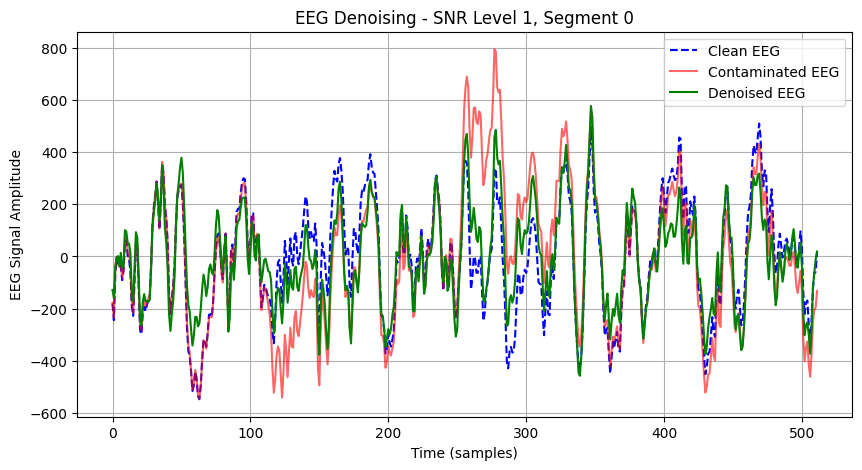

In [35]:
import matplotlib.pyplot as plt

# Select SNR level 1
snr_level = 1
snr_idx = list(sorted(linear_synthetic_data.keys())).index(snr_level)  # Get index of SNR=1 in test list

# Get test data for SNR=1
noisy_snr = X_test_list[snr_idx]  # Noisy (contaminated) EEG from test set
clean_snr = Y_test_list[snr_idx]  # Clean EEG from test set

# Convert to PyTorch tensor and denoise
noisy_tensor = torch.tensor(noisy_snr, dtype=torch.float32).to(device)
denoised_tensor = model(noisy_tensor).cpu().detach().numpy()

# Select the 0th segment (first sample)
segment_idx = 0
noisy_segment = noisy_snr[segment_idx]
clean_segment = clean_snr[segment_idx]
denoised_segment = denoised_tensor[segment_idx]

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(clean_segment, label="Clean EEG", color="blue", linestyle="dashed", linewidth=1.5)
plt.plot(noisy_segment, label="Contaminated EEG", color="red", alpha=0.6)
plt.plot(denoised_segment, label="Denoised EEG", color="green", linewidth=1.5)

plt.xlabel("Time (samples)")
plt.ylabel("EEG Signal Amplitude")
plt.title(f"EEG Denoising - SNR Level {snr_level}, Segment {segment_idx}")
plt.legend()
plt.grid(True)
plt.show()
